# Distinguishing the Author: An NLP Analysis of Cohesion in Human vs. AI-Generated Essays


**Research-Paper**

**Cohesion**

**Susheel Srikanth & Vaibhav Gupta**

## Setting Up the Analysis Environment

In [ ]:
import spacy
from spacy import displacy
from spacy.util import minibatch
from google.colab import drive
import pandas as pd
import numpy as np
from tqdm import tqdm
from scipy import stats
from scipy.stats import mannwhitneyu
from scipy.stats import ttest_ind
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import openai
import time

## Dataset Preparation

### Data Preparation for Semantic Cohesion Analysis of High-Level TOEFL Essays

This script performs the initial data preparation steps for a study on semantic cohesion in high-level essays written by non-native English speakers. The dataset, sourced from TOEFL essays, contains over 11,000 entries with varying proficiency levels and native languages. The code begins by loading the dataset and marking all entries as human-generated. It then filters the essays to include only those classified as 'high' level and authored by individuals with Hindi (HIN), Chinese (CHI), or Spanish (SPA) as their first language. After filtering, the dataset is further refined by sampling 248 essays from each language group to ensure a balanced representation. Finally, the script analyzes the distribution of prompts across the sampled essays to maintain prompt neutrality in subsequent analyses. The resulting filtered and sampled dataset is ready for deeper NLP tasks, such as calculating sentence similarity to explore semantic cohesion.

In [ ]:
# Load the dataset from a CSV file, specifying the character encoding
df = pd.read_csv("/content/toefl_nli_texts_and_data.csv", encoding='ISO-8859-1')

# Add a new column 'generated' with all values set to 0 (denoting human-generated text)
df["generated"] = 0

# Filter the dataframe to only include high-level essays from speakers of specific L1 languages
filtered_df = df[(df['Level'] == 'high') & (df['L1'].isin(['HIN', 'CHI', 'SPA']))]

# Save the filtered dataframe to a new CSV file
filtered_df.to_csv("/content/filtered_file1.csv", index=False)

# Calculate and print the number of high-level essays for each of the specified L1 languages
counts = filtered_df['L1'].value_counts()
print(counts)



L1
HIN    576
SPA    425
CHI    248
Name: count, dtype: int64


In [ ]:
# Sample 248 essays for each of the three specified L1 languages to create a balanced dataset
sampled_df_chi = filtered_df[filtered_df['L1'] == 'CHI'].sample(n=248, random_state=1)
sampled_df_hin = filtered_df[filtered_df['L1'] == 'HIN'].sample(n=248, random_state=1)
sampled_df_spa = filtered_df[filtered_df['L1'] == 'SPA'].sample(n=248, random_state=1)

# Combine the sampled dataframes into one, forming a balanced dataset for analysis
sampled_df = pd.concat([sampled_df_chi, sampled_df_hin, sampled_df_spa])

# Randomly display 5 rows from the combined sampled dataframe to check the data
sampled_df.sample(5)

,id,text,prompt,L1,Level,generated
7,1000719.txt,I disagree with the issue that a person should...,P1,HIN,high,0
7841,492111.txt,To specialize in one specific subject is reall...,P1,HIN,high,0
6857,337855.txt,Do younger people enjoy life more than older p...,P2,HIN,high,0
9384,737613.txt,"Historically , people have aquired knowledge i...",P1,SPA,high,0
7030,36328.txt,"In general , I would say that both are importa...",P7,SPA,high,0


In [ ]:
sampled_df.to_csv("/content/human_file.csv", index=False)

In [ ]:
# Count the number of occurrences of each prompt for each language
prompt_counts = sampled_df.groupby(['L1', 'prompt']).size().reset_index(name='count')

# Sort the counts for better readability
prompt_counts_sorted = prompt_counts.sort_values(by=['L1', 'prompt'])
prompt_counts_sorted

,L1,prompt,count
0,CHI,P1,36
1,CHI,P2,36
2,CHI,P3,36
3,CHI,P4,29
4,CHI,P5,33
5,CHI,P6,42
6,CHI,P7,23
7,CHI,P8,13
8,HIN,P1,38
9,HIN,P2,38


### Integration of Human and AI-Generated Essay Data for Cohesion Analysis
Following the preparation of the human-authored TOEFL essay dataset, this script describes the process of generating a parallel corpus of AI-generated essays.

### AI essay generator code(Just sample code)
This sample code snippet demonstrates the methodology I employed to generate AI essays using the OpenAI API with the GPT-3.5-turbo model.

In [ ]:
# Set your OpenAI API key from an environment variable or string literal
openai.api_key = 'Enter your api key'

# Define a base prompt that will be used to generate AI essays
base_prompt = (
    "Do you agree or disagree with the statement that successful people try new things "
    "and take risks rather than only doing what they already know how to do well? "
    "Provide reasons and examples to support your opinion. Aim for an essay of around "
    "200 words and demonstrate high English proficiency."
)

# A list of variations to slightly modify the base prompt for diversity in AI responses
variations = [
    "Please write with a focus on providing clear arguments.",
    "Use a narrative style to convey your points.",
    "Incorporate rhetorical questions to engage the reader.",
    "Employ a diverse vocabulary to enrich your essay.",
    "Argue strongly against the statement.",
    "Argue strongly for the statement.",
    "Ensure clarity and conciseness in your explanation.",
    "Use examples to substantiate your claims."
]

# Function to generate a specified number of AI essays, each with a unique prompt variation
def generate_varied_essays(prompt, n=35, temperature=0.7, max_tokens=700):
    essays = []  # List to store the generated essays
    for i in range(n):
        # Combine base prompt with a cyclically-selected variation
        variation_prompt = prompt + variations[i % len(variations)]
        # Call the OpenAI API to generate an AI response based on the varied prompt
        response = openai.ChatCompletion.create(
            model="gpt-3.5-turbo-0125",
            messages=[
                {
                    "role": "system",
                    "content": "You are a highly proficient English writer asked to write an essay."
                },
                {
                    "role": "user",
                    "content": variation_prompt
                }
            ],
            temperature=temperature,
            max_tokens=max_tokens,
            stop=None,
        )
        # Append the generated essay to the list
        essays.append(response.choices[0].message['content'])
        # Sleep for 1 second to avoid hitting API rate limits
        time.sleep(1)
    return essays

# Generate a collection of essays with varied prompts
essays = generate_varied_essays(base_prompt)

# Replace the text in a dataframe with AI-generated essays based on certain conditions
for i, essay in enumerate(essays):
    # Define the condition for replacing the essays (e.g., Spanish L1 and prompt 'P8')
    condition = (df4['L1'] == 'SPA') & (df4['t'promp] == 'P8')
    indices = df4.index[condition]  # Find the indices in the dataframe that meet the condition
    if i < len(indices):
        # Assign the AI-generated essay to the corresponding row in the dataframe
        df4.at[indices[i], 'text'] = essay

# Save the updated dataframe with AI-generated essays to a CSV file
df4.to_csv("C:\\Users\\sushe\\OneDrive\\Desktop\\MS Data Science\\NLP Research\\AI_trial.csv", index=False)

After using the above code the AI dataset in csv was created.

In [ ]:
df1=pd.read_csv("/content/AI_trial.csv",encoding='ISO-8859-1')
df1.head()

,generated,text,prompt,L1,Level
0,1,I firmly agree with the statement that success...,P8,CHI,high
1,1,I disagree with the statement that there will ...,P5,CHI,high
2,1,I wholeheartedly agree with the statement that...,P8,CHI,high
3,1,I agree that understanding ideas and concepts ...,P7,CHI,high
4,1,Advertising plays a pivotal role in shaping co...,P4,CHI,high


In [ ]:
df2=pd.read_csv("/content/human_file.csv",encoding='ISO-8859-1')
df2.head()

,id,text,prompt,L1,Level,generated
0,1468002.txt,"When people think of successful people , they ...",P8,CHI,high,0
1,989614.txt,"As a mater of fact , the issue of whether ther...",P5,CHI,high,0
2,70661.txt,I agree with the statement that successful peo...,P8,CHI,high,0
3,81437.txt,"As a student myself , the question of whether ...",P7,CHI,high,0
4,1591671.txt,"No matter where you go , you 'll always be con...",P4,CHI,high,0


In [ ]:
# Concatenate the two DataFrames
merged_df = pd.concat([df1, df2], ignore_index=True)

# If you need to sort the merged DataFrame based on 'L1' and 'prompt', you can do so
merged_df.sort_values(by=['L1', 'prompt'], inplace=True)

# Reset the index of the merged DataFrame if needed
merged_df.reset_index(drop=True, inplace=True)
mergef_df.sample(5)

In [ ]:
merged_df.shape
merged_df.to_csv("/content/Ai_human_file.csv", index=False) # The final dataset

(1488, 6)

In [ ]:
ah_df=pd.read_csv("/content/Ai_human_file.csv",encoding='ISO-8859-1') # The final dataset
ah_df.sample(5)

In [ ]:
!!python -m spacy download en_core_web_lg

## NLP Analysis of Semantic Cohesion in Combined Human and AI-Generated Essays
This section of the analysis involves applying Natural Language Processing (NLP) techniques to the merged dataset of human and AI-generated essays to assess semantic,lexical and referential cohesion.

In [ ]:
nlp = spacy.load('en_core_web_lg')

## Referential Cohesion

In [ ]:

# Function to calculate a sophisticated cohesion score for an essay
def calculate_sophisticated_cohesion_score(essay):
    doc = nlp(essay)
    noun_count = 0
    pronoun_reference_count = 0
    entity_tracker = {}
    sentence_boundaries = [sent.start for sent in doc.sents]

    for token in doc:
        if token.pos_ in ['NOUN', 'PROPN']:
            noun_count += 1
            entity_tracker[token.lemma_] = token.i  # Track the position of the noun
        elif token.pos_ == 'PRON':
            # Find the nearest suitable noun antecedent within sentence boundaries
            candidate_antecedents = [(entity, idx) for entity, idx in entity_tracker.items() if idx < token.i]
            if candidate_antecedents:
                # Sort by proximity to the pronoun, prioritizing recent mentions
                sorted_antecedents = sorted(candidate_antecedents, key=lambda x: token.i - x[1], reverse=True)
                nearest_antecedent, position = sorted_antecedents[0]
                # Check if the antecedent is within the same or adjacent sentences
                if any(boundary <= position < token.i for boundary in sentence_boundaries):
                    pronoun_reference_count += 1
                    # Update the entity tracker with the most recent reference
                    entity_tracker[nearest_antecedent] = token.i

    # Calculate cohesion score with weighted references
    cohesion_score = pronoun_reference_count / noun_count if noun_count > 0 else 0
    return cohesion_score

# Apply the sophisticated cohesion score calculation to each essay
ah_df['referential_cohesion_score'] = ah_df['text'].apply(calculate_sophisticated_cohesion_score)

# Display the DataFrame with the new sophisticated cohesion score column
print(ah_df[['text', 'referential_cohesion_score']].head())


                                                text  \
0  The dichotomy between broad knowledge and spec...   
1  The choice between broad knowledge and special...   
2  The educational landscape often presents a cho...   
3  The educational choice between broad knowledge...   
4  In the context of academic pursuits, the choic...   

   referential_cohesion_score  
0                    0.087719  
1                    0.122807  
2                    0.092593  
3                    0.117647  
4                    0.118644  


## Semantic Cohesion

In [ ]:
# Function to clean the text by removing stopwords, but keeping full stops
def clean_text(text):
    doc = nlp(text)
    clean_tokens = [token.text for token in doc if not token.is_stop and (token.text.isalpha() or token.text == '.')]
    return ' '.join(clean_tokens)

# Function to calculate the mean similarity between adjacent sentences
def mean_adjacent_similarity(text):
    doc = nlp(text)
    similarities = []
    sents = list(doc.sents)
    for i in range(len(sents) - 1):
        if sents[i].has_vector and sents[i + 1].has_vector:  # Ensure both sentences have vectors
            similarity_score = sents[i].similarity(sents[i + 1])
            similarities.append(similarity_score)
    return sum(similarities) / len(similarities) if similarities else 0

# Apply the cleaning function
texts = ah_df['text'].tolist()
cleaned_texts = [clean_text(doc) for doc in nlp.pipe(texts, disable=["parser", "ner"])]
ah_df['cleaned_text'] = cleaned_texts

# Apply the similarity function
ah_df['mean_adj_similarity'] = [mean_adjacent_similarity(doc) for doc in nlp.pipe(ah_df['cleaned_text'], disable=["ner"])]

## Lexical Cohesion

In [ ]:
from collections import Counter
# Function to calculate lexical cohesion
def lexical_cohesion(cleaned_text):
    # Process the cleaned text with SpaCy
    doc = nlp(cleaned_text)

    # Count the frequency of each lemma in the cleaned text
    lemma_freq = Counter(token.lemma_ for token in doc if not token.is_punct and token.pos_ != 'PRON')

    # Calculate the number of unique lemmas
    unique_lemmas = len(lemma_freq)

    # Calculate the total number of lemmas
    total_lemmas = sum(lemma_freq.values())

    # Calculate lexical diversity as the ratio of unique lemmas to total lemmas
    lexical_diversity = unique_lemmas / total_lemmas if total_lemmas > 0 else 0

    return lexical_diversity

# Apply the lexical cohesion function to each cleaned text in the DataFrame
ah_df['lexical_cohesion'] = ah_df['cleaned_text'].apply(lexical_cohesion)

# Output the modified DataFrame
print(ah_df[['cleaned_text', 'lexical_cohesion']])

                                           cleaned_text  lexical_cohesion
0     dichotomy broad knowledge specialization educa...          0.794643
1     choice broad knowledge specialization presents...          0.800000
2     educational landscape presents choice acquirin...          0.884615
3     educational choice broad knowledge specializat...          0.861386
4     context academic pursuits choice broad knowled...          0.819048
...                                                 ...               ...
1483  agree statement think know good learn new . th...          0.464912
1484  agree successful people try new things risks k...          0.462585
1485  risks successfull ones . professors Spanish Ec...          0.679245
1486  person pushes better individual . looking forw...          0.693548
1487  people like learned family society passed year...          0.768595

[1488 rows x 2 columns]


## Final dataset for Model

In [ ]:
ah_df.sample(5)

,text,prompt,L1,Level,generated,referential_cohesion_score,cleaned_text,mean_adj_similarity,lexical_cohesion
26,The educational debate between broad knowledge...,P1,CHI,high,1,0.089286,educational debate broad knowledge deep specia...,0.890447,0.778761
267,"Nowadays , people make their advertisements so...",P4,CHI,high,0,0.914286,Nowadays people advertisements good people pur...,0.703559,0.634483
600,I believe that the statement claiming young pe...,P2,HIN,high,1,0.173913,believe statement claiming young people enjoy ...,0.821535,0.710744
1290,I strongly disagree with the statement that th...,P6,SPA,high,1,0.151515,strongly disagree statement best way travel gr...,0.813746,0.694030
766,"I agree with the statement that , `` Most adve...",P4,HIN,high,0,0.311828,agree statement advertisements products better...,0.783361,0.601190


In [ ]:
# Display statistical summary of cohesion features
print(ah_df[['mean_adj_similarity', 'lexical_cohesion', 'referential_cohesion_score']].describe())

       mean_adj_similarity  lexical_cohesion  referential_cohesion_score
count          1488.000000       1488.000000                 1488.000000
mean              0.809520          0.685228                    0.318276
std               0.064347          0.091569                    0.225332
min               0.000000          0.362319                    0.016129
25%               0.767397          0.633333                    0.153846
50%               0.818221          0.691267                    0.250000
75%               0.860473          0.742923                    0.436118
max               0.928575          0.953846                    1.725490


## Visualizing Cohesion in AI and Human-Generated Essays

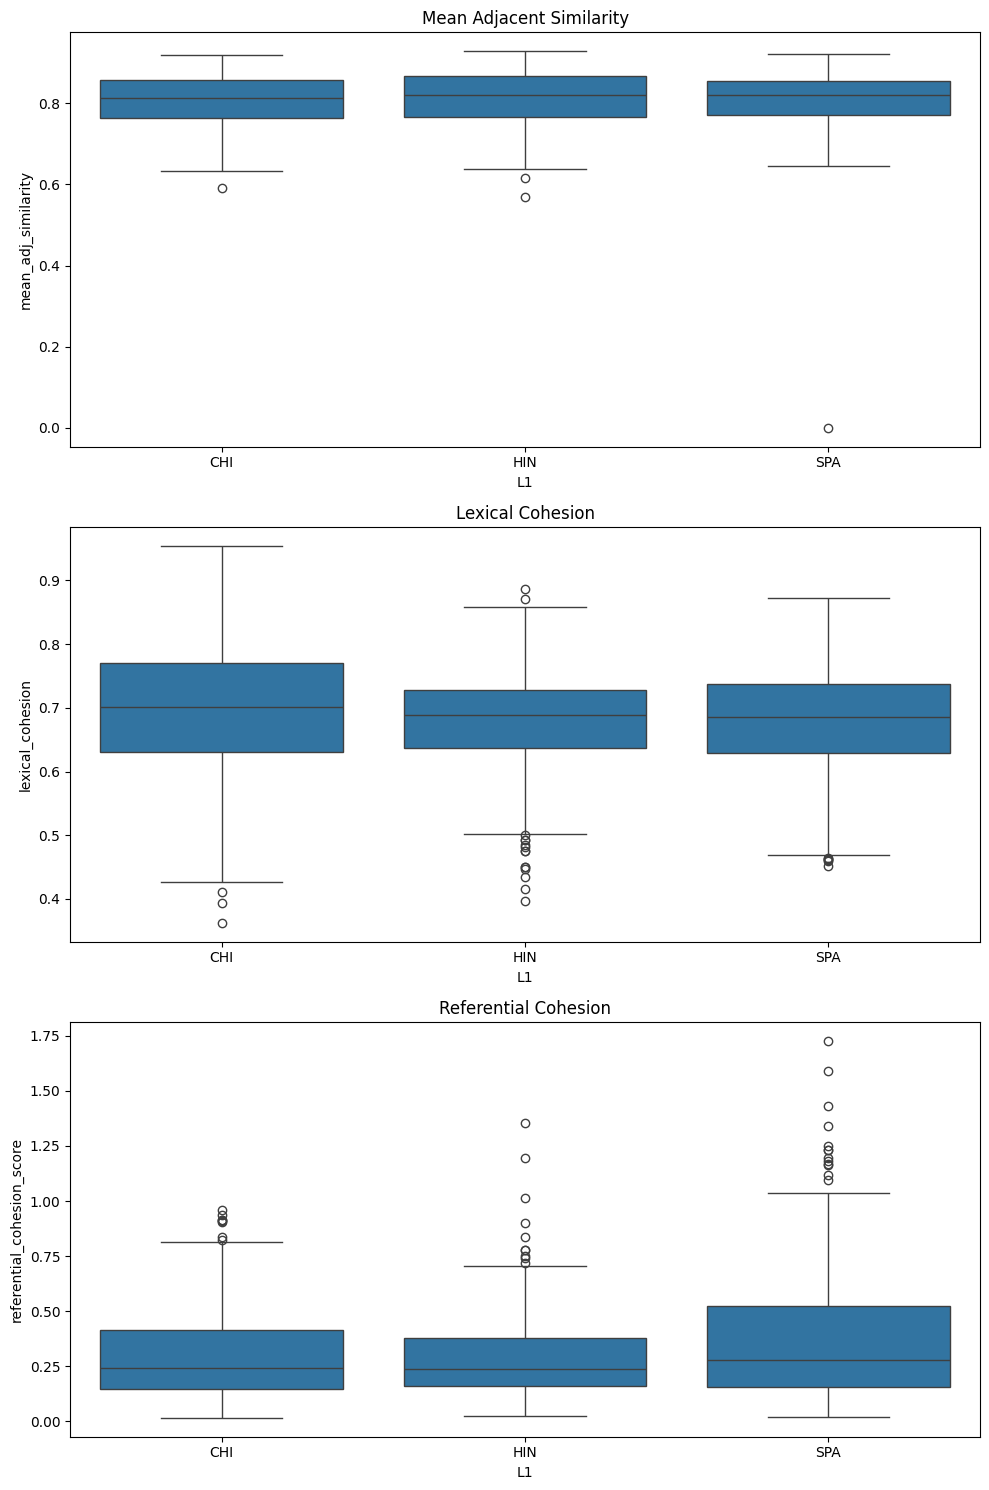

In [ ]:
# Boxplots of cohesion features by 'L1' label
fig, axes = plt.subplots(3, 1, figsize=(10, 15))
sns.boxplot(x='L1', y='mean_adj_similarity', data=ah_df, ax=axes[0])
sns.boxplot(x='L1', y='lexical_cohesion', data=ah_df, ax=axes[1])
sns.boxplot(x='L1', y='referential_cohesion_score', data=ah_df, ax=axes[2])
axes[0].set_title('Mean Adjacent Similarity')
axes[1].set_title('Lexical Cohesion')
axes[2].set_title('Referential Cohesion')
plt.tight_layout()
plt.show()

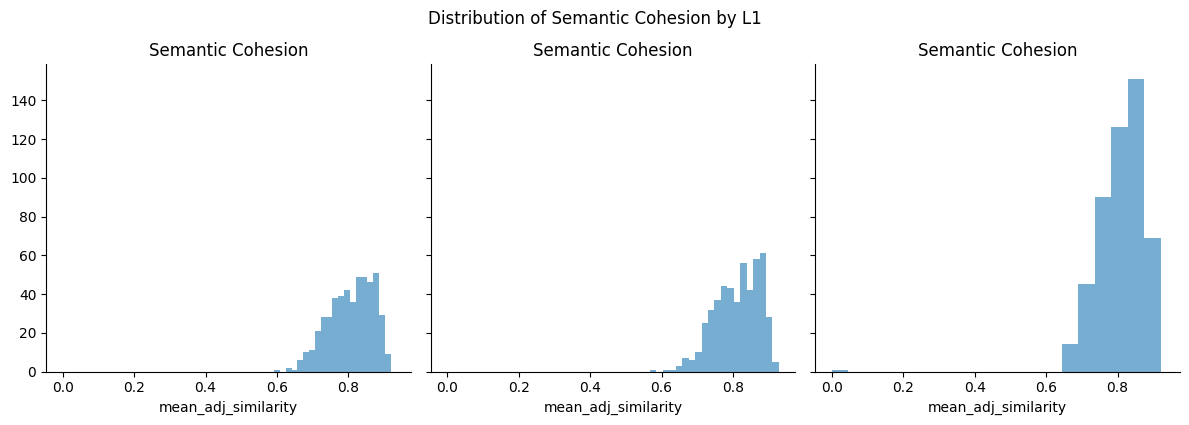

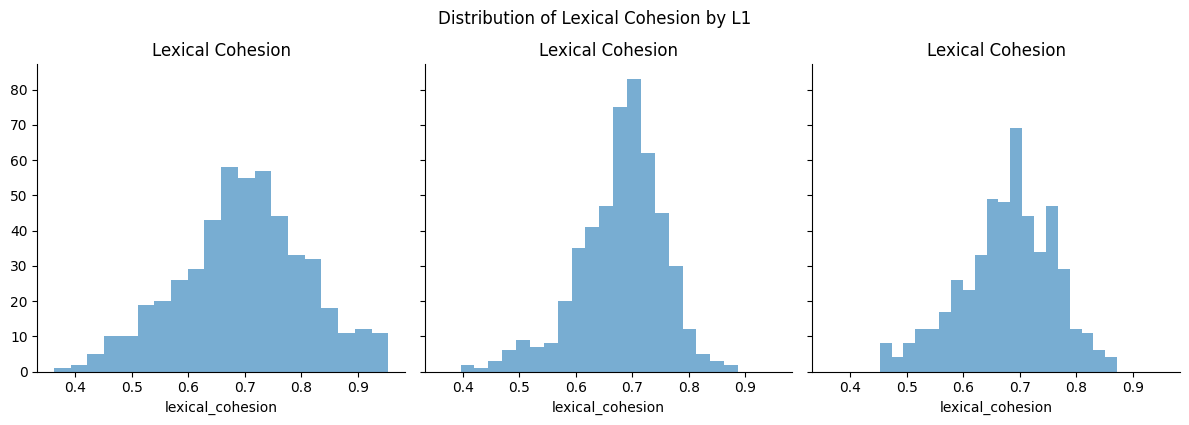

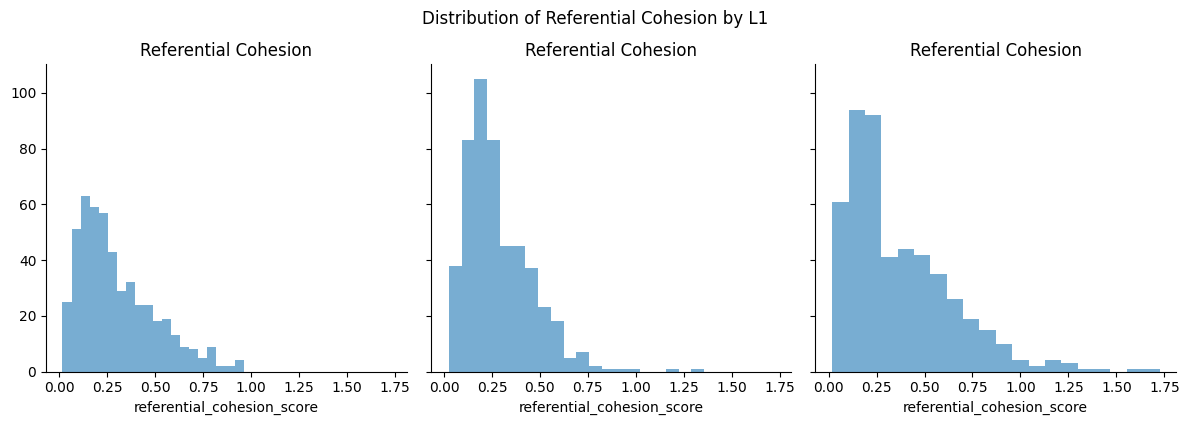

In [ ]:
# Mapping of original feature names to desired titles
titles = {
    'mean_adj_similarity': 'Semantic Cohesion',
    'lexical_cohesion': 'Lexical Cohesion',
    'referential_cohesion_score': 'Referential Cohesion'
}

# Loop through each feature and create a histogram
for feature in ['mean_adj_similarity', 'lexical_cohesion', 'referential_cohesion_score']:
    g = sns.FacetGrid(ah_df, col='L1', height=4, aspect=1)
    g.map(plt.hist, feature, bins=20, alpha=0.6)

    # Set the title for each subplot using the titles dictionary
    for ax, label in zip(g.axes.flatten(), g.col_names):
        ax.set_title(titles[feature])

    # Adjust the main title of the figure
    g.fig.suptitle(f'Distribution of {titles[feature]} by L1', y=1.05)

    plt.show()




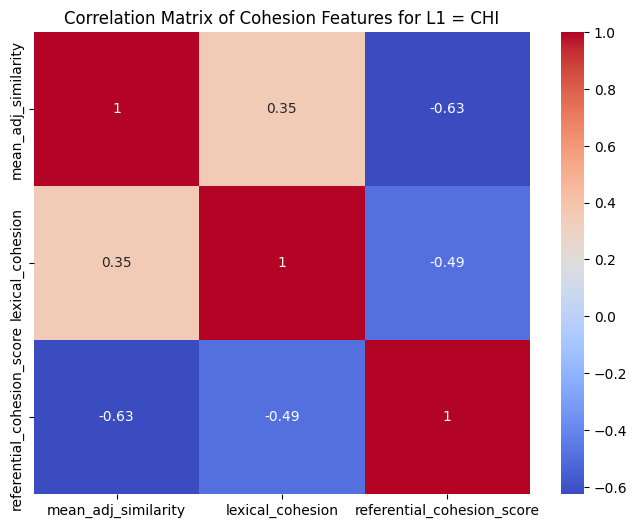

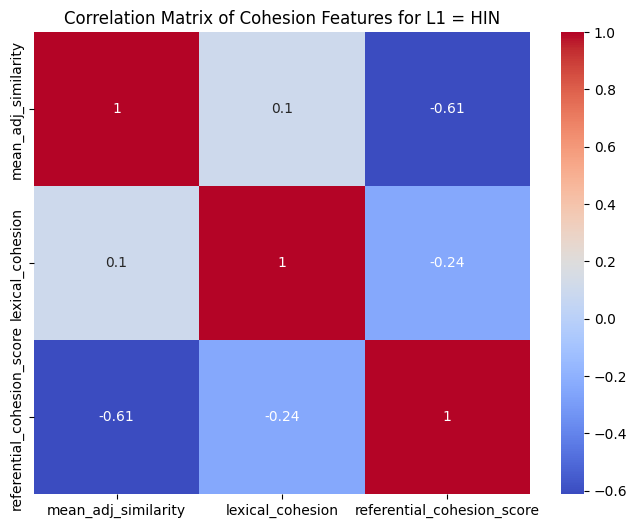

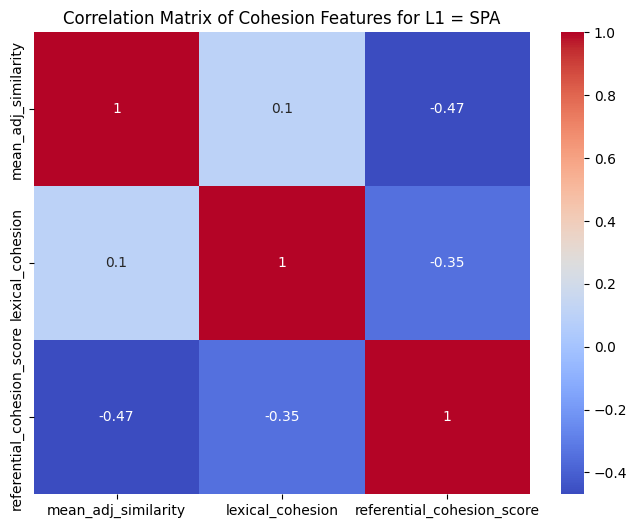

In [ ]:
# Correlation matrices of cohesion features by 'L1' label
for language in ah_df['L1'].unique():
    plt.figure(figsize=(8, 6))
    correlation_matrix = ah_df[ah_df['L1'] == language][['mean_adj_similarity', 'lexical_cohesion', 'referential_cohesion_score']].corr()
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
    plt.title(f'Correlation Matrix of Cohesion Features for L1 = {language}')
    plt.show()

## Visualizing AI vs Human


<ipython-input-21-b9d6a6b3f2b3>:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(custom_labels)


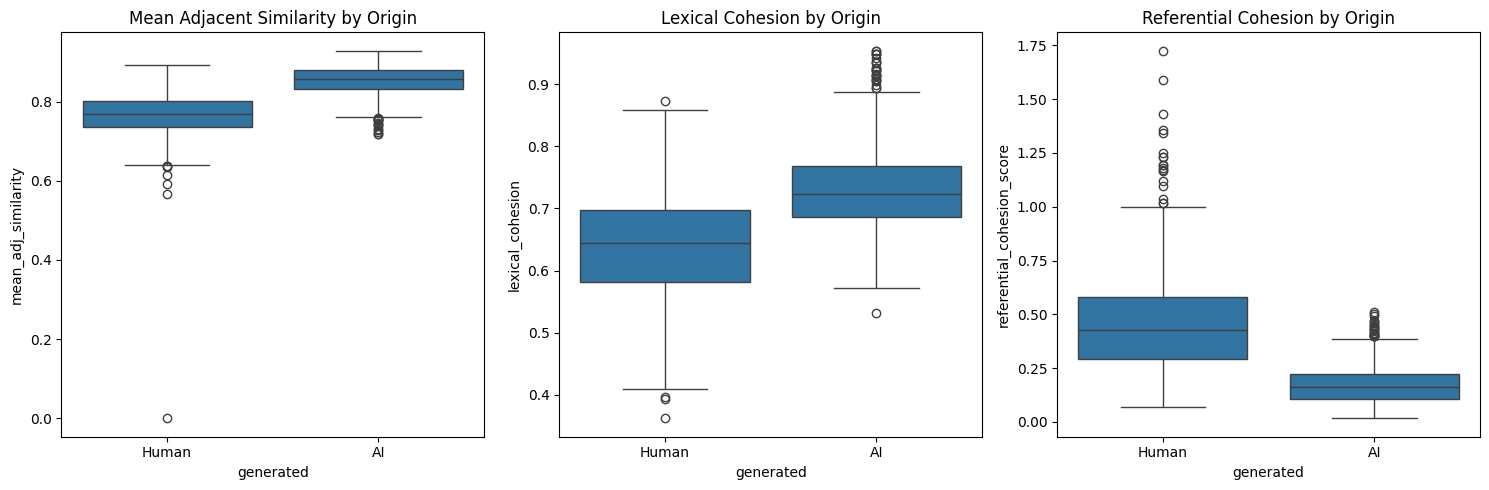

In [ ]:
# Boxplots of cohesion features by 'generated' label
# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Create boxplots
sns.boxplot(x='generated', y='mean_adj_similarity', data=ah_df, ax=axes[0])
sns.boxplot(x='generated', y='lexical_cohesion', data=ah_df, ax=axes[1])
sns.boxplot(x='generated', y='referential_cohesion_score', data=ah_df, ax=axes[2])

# Set titles for each subplot
axes[0].set_title('Mean Adjacent Similarity by Origin')
axes[1].set_title('Lexical Cohesion by Origin')
axes[2].set_title('Referential Cohesion by Origin')

# Set custom x-axis labels for each subplot
custom_labels = ['Human', 'AI']
for ax in axes:
    ax.set_xticklabels(custom_labels)

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

## ML Model - Random Forest Classifier

In [ ]:
# Define the feature names as used in the original training data
feature_names = ['mean_adj_similarity', 'lexical_cohesion', 'referential_cohesion_score']

# Define the feature matrix (X) and the target vector (y)
X = ah_df[feature_names]
y = ah_df['generated']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the StandardScaler
scaler = StandardScaler()

# Fit the scaler on the training data and transform both the training and testing data
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize the RandomForestClassifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
rf_classifier.fit(X_train_scaled, y_train)

# Predict the labels for the testing set
y_pred = rf_classifier.predict(X_test_scaled)

# Evaluate the model's performance
print("Classification Report:")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("Accuracy Score:")
print(accuracy_score(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.89      0.89       151
           1       0.89      0.90      0.89       147

    accuracy                           0.89       298
   macro avg       0.89      0.89      0.89       298
weighted avg       0.89      0.89      0.89       298

Confusion Matrix:
[[134  17]
 [ 15 132]]
Accuracy Score:
0.8926174496644296


## RQ2 What are the linguistic features that are predictive?

In [ ]:
# Get feature importances from the RandomForestClassifier
importances = rf_classifier.feature_importances_

# Print the feature importances
print("Feature Importances:")
for feature, importance in zip(feature_names, importances):
    print(f"{feature}: {importance:.4f}")

Feature Importances:
mean_adj_similarity: 0.4205
lexical_cohesion: 0.2496
referential_cohesion_score: 0.3299


## RQ3  Are there differences in classification accuracy based on the first language (L1) of the L2 writers?

In [ ]:
print("\nAccuracy by L1:")
for l1 in ah_df['L1'].unique():
    l1_data = ah_df[ah_df['L1'] == l1]
    X_l1 = l1_data[feature_names]
    y_l1 = l1_data['generated']
    X_l1_scaled = scaler.transform(X_l1)  # Use the same scaler as before
    y_l1_pred = rf_classifier.predict(X_l1_scaled)
    accuracy_l1 = accuracy_score(y_l1, y_l1_pred)
    print(f"Accuracy for L1 {l1}: {accuracy_l1}")


Accuracy by L1:
Accuracy for L1 CHI: 0.9798387096774194
Accuracy for L1 HIN: 0.9758064516129032
Accuracy for L1 SPA: 0.9798387096774194


## RQ4: Are there differences in classification accuracy based on the writing prompt?

In [ ]:
print("\nAccuracy by Prompt:")
for prompt in ah_df['prompt'].unique():
    prompt_data = ah_df[ah_df['prompt'] == prompt]
    X_prompt = prompt_data[feature_names]
    y_prompt = prompt_data['generated']
    X_prompt_scaled = scaler.transform(X_prompt)  # Use the same scaler as before
    y_prompt_pred = rf_classifier.predict(X_prompt_scaled)
    accuracy_prompt = accuracy_score(y_prompt, y_prompt_pred)
    print(f"Accuracy for prompt {prompt}: {accuracy_prompt}")


Accuracy by Prompt:
Accuracy for prompt P1: 0.9722222222222222
Accuracy for prompt P2: 0.9864864864864865
Accuracy for prompt P3: 0.9941176470588236
Accuracy for prompt P4: 0.9810126582278481
Accuracy for prompt P5: 0.985981308411215
Accuracy for prompt P6: 0.978021978021978
Accuracy for prompt P7: 0.989247311827957
Accuracy for prompt P8: 0.9285714285714286


## RQ5: Are there differences in classification accuracy by L1 and prompt?

In [ ]:
print("\nAccuracy by L1 and Prompt:")
for l1 in ah_df['L1'].unique():
    for prompt in ah_df['prompt'].unique():
        group_data = ah_df[(ah_df['L1'] == l1) & (ah_df['prompt'] == prompt)]
        if not group_data.empty:
            X_group = group_data[feature_names]
            y_group = group_data['generated']
            X_group_scaled = scaler.transform(X_group)  # Use the same scaler as before
            y_group_pred = rf_classifier.predict(X_group_scaled)
            accuracy_group = accuracy_score(y_group, y_group_pred)
            print(f"Accuracy for L1 {l1} and prompt {prompt}: {accuracy_group}")


Accuracy by L1 and Prompt:
Accuracy for L1 CHI and prompt P1: 0.9861111111111112
Accuracy for L1 CHI and prompt P2: 0.9722222222222222
Accuracy for L1 CHI and prompt P3: 0.9861111111111112
Accuracy for L1 CHI and prompt P4: 0.9827586206896551
Accuracy for L1 CHI and prompt P5: 1.0
Accuracy for L1 CHI and prompt P6: 0.9642857142857143
Accuracy for L1 CHI and prompt P7: 1.0
Accuracy for L1 CHI and prompt P8: 0.9230769230769231
Accuracy for L1 HIN and prompt P1: 0.9605263157894737
Accuracy for L1 HIN and prompt P2: 0.9868421052631579
Accuracy for L1 HIN and prompt P3: 1.0
Accuracy for L1 HIN and prompt P4: 1.0
Accuracy for L1 HIN and prompt P5: 0.975609756097561
Accuracy for L1 HIN and prompt P6: 1.0
Accuracy for L1 HIN and prompt P7: 0.9736842105263158
Accuracy for L1 HIN and prompt P8: 0.9090909090909091
Accuracy for L1 SPA and prompt P1: 0.9705882352941176
Accuracy for L1 SPA and prompt P2: 1.0
Accuracy for L1 SPA and prompt P3: 1.0
Accuracy for L1 SPA and prompt P4: 0.967741935483871